## Import Libraries

In [19]:
%matplotlib inline

In [78]:
import pandas as pd
import numpy as np
import json
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

## Visualize pass actions

- We will maybe not yet be able to give half-time advice but we will learn ways to visualise the data in the way that helps coaching staff understand the game better.


## Collecting Data

In [116]:
lineups_path = '../data/StatsBomb/Data/ManCity_Arsenal_lineups.json'
events_path = '../data/StatsBomb/Data/ManCity_Arsenal_events.json'

In [117]:
# Open the file and load its contents into a dictionary
with open('../data/StatsBomb/Data/ManCity_Arsenal_events.json', 'r') as f:
    data = json.load(f)
    
# Collect a selected lineup
with open(lineups_path, 'r') as f:
    lineups = json.load(f)

In [118]:
# Convert the list of JSON values to a DataFrame
df = pd.json_normalize(data, sep="_")

In [119]:
names_dict = {player["player_name"]: player["player_name"].split(" ")[-1] for team in lineups for player in team["lineup"]}

In [23]:
teams_comp = list(df['team_name'].value_counts().keys())

## Preparing the data
For passing networks we use only accurate/successful passes made by a team until the first substitution.
This is mainly just to get going and there are several possible variations of this.
We need information about pass start and end location as well as player who made and received the pass. 
To make the vizualisation clearer, we annotate the players using their surname.
(This works for English women side, since players' surnames  are single-barrelled. But
can cause problems.For example, Leo Messi's name in Statsbomb is Lionel Andrés Messi Cuccittini. So the
name Cuccittini will come up if you run this code on his matches!).

In [24]:
def prepare_data_pass(df,team_name,sub=True):
    #check for index of first sub
    if sub:
        sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == team_name].iloc[0]["index"]

    #make df with successfull passes by Manchester City until the first substitution
    if sub:
        mask_mancity = (df['type_name'] == 'Pass')\
        & (df['team_name']==team_name) \
        & (df.index < sub) \
        &(df['substitution_replacement_name'].isnull())\
        &(~df['pass_recipient_name'].isnull())
    else:
        mask_mancity = (df['type_name'] == 'Pass')\
        & (df['team_name']==team_name) \
        &(df['substitution_replacement_name'].isnull())\
        &(~df['pass_recipient_name'].isnull()) 

    #taking necessary columns
    df_pass_details = df.loc[mask_mancity, ['location','pass_end_location','player_name','pass_recipient_name','minute']]

    df_pass_details['x'] = [axes[0] for axes in df_pass_details['location'].values]
    df_pass_details['y'] = [axes[1] for axes in df_pass_details['location'].values]

    df_pass_details['end_x'] = [axes[0] for axes in df_pass_details['pass_end_location'].values]
    df_pass_details['end_y'] = [axes[1] for axes in df_pass_details['pass_end_location'].values]

    df_pass = df_pass_details[['x', 'y', 'end_x', 'end_y','player_name','pass_recipient_name','minute']]

    #adjusting that only the surname of a player is presented.
    df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
    df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])
    return df_pass

## Calculating vertices size and location
To calculate vertices size and location, first we create an empty dataframe.
For each player we calculate average location of passes made and receptions.
Then, we calculate number of passes made by each player.
As the last step, we calculate set he marker size to be proportional to number of passes.

In [25]:
def calculate_vertices(df_pass):
    scatter_df = pd.DataFrame()
    for i, name in enumerate(df_pass["player_name"].unique()):
        passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
        recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
        passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
        recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
        scatter_df.at[i, "player_name"] = name
        #make sure that x and y location for each circle representing the player is the average of passes and receptions
        scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
        scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
        #calculate number of passes
        scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

    #adjust the size of a circle so that the player who made more passes 
    scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)
    return scatter_df

## Calculating edges width
To calculate edge width we again look at the number of passes between players
We need to group the dataframe of passes by the combination of passer and recipient and count passes between them.
As the last step, we set the threshold ignoring players that made fewer than 2 passes.
You can try different thresholds and investigate how the passing network changes when you change it.
It is recommended that you tune this depedning on the message behind your visualisation.

In [26]:
#counting passes between players
def calculate_edges_width(df_temp):
    df_pass = df_temp.copy()
    df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
    lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
    lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
    #setting a treshold. You can try to investigate how it changes when you change it.
    lines_df = lines_df[lines_df['pass_count']>2]
    scatter_df = calculate_vertices(df_pass)
    return df_pass,lines_df,scatter_df

## Passing Networks

- A passing network can really tell the story of a game
- **Get the real idea of formation of where the players are located on the pitch**
    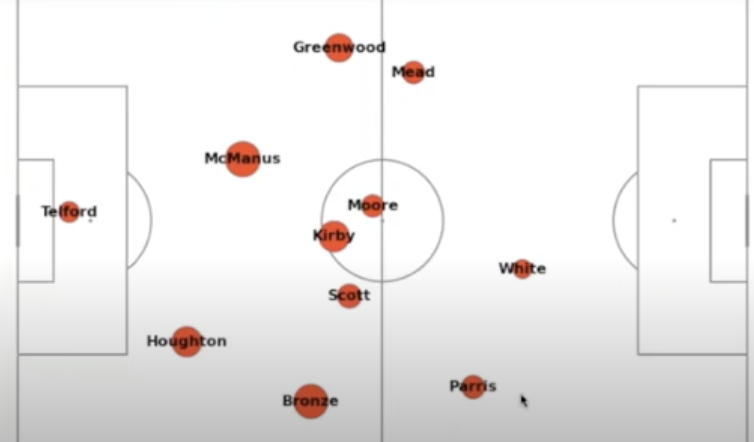
- Each point represents a player
- Thicker lines indicate a higher number of passes
- It’s immediately clear that Italy made a lot more successful passes than England
- Carroll managed to win the ball so many times from Hart’s kicks. Despite being on the pitch only half as long as most of the other players, he was one end of England’s most successful passing partnership
- But Hart and Carroll’s success reveals failures elsewhere. England had no consistent passing network in midfield. Instead, the Italians dominated the match, with 68% of possession and 36 shots. Italy passed the ball forward and England tried to kick it over their heads.
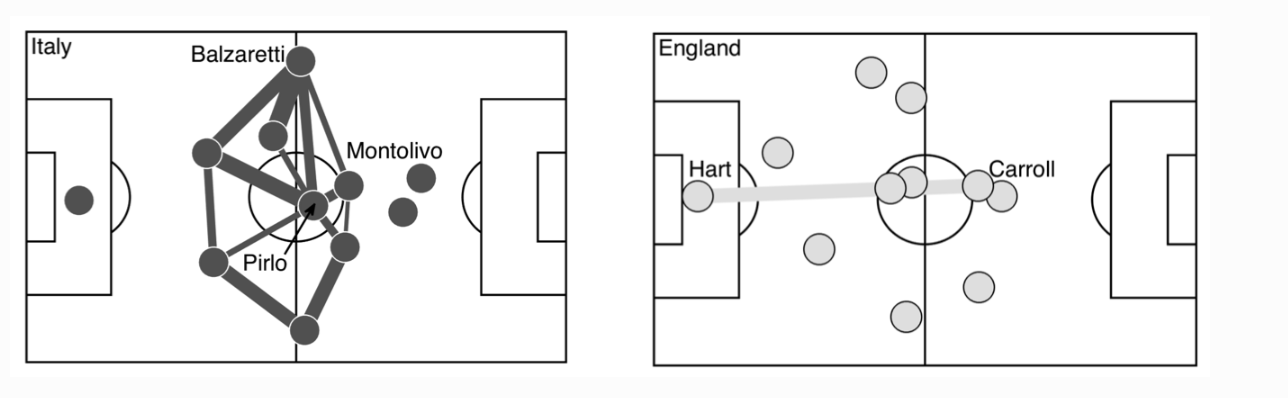

## Plotting edges
For each combination of players who made passes, we make a query to *scatter_df* to get the start and end of the line.
Then we adjust the line width so that the more passes between players, the wider the line.
As the next step, we plot the lines on the pitch. It is recommended that zorder of edges is lower than zorder of vertices.
In the end, we make the title.

In [27]:
#plot once again pitch and vertices
def plotting_edges(team_dict,debug=False):
    if debug:
        import pdb;pdb.set_trace()
    # get the information regarding the passes between the home team     
    df_pass = team_dict['df_pass']
    lines_df = team_dict['lines_df']
    team_color = team_dict['color']
    team_name = team_dict['team_name']
    scatter_df = team_dict['scatter_df']
    
    pitch = Pitch(line_color='grey')
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)
    
    # Plot the node per player     
    pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color=team_color, edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
    for i, row in scatter_df.iterrows():
        pitch.annotate(row['player_name'], xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 7)

    for i, row in lines_df.iterrows():
            player1 = row["pair_key"].split("_")[0]
            player2 = row['pair_key'].split("_")[1]
            #take the average location of players to plot a line between them 
            player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
            player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
            player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
            player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
            num_passes = row["pass_count"]
            #adjust the line width so that the more passes, the wider the line
            line_width = (num_passes / lines_df['pass_count'].max() * 10)
            #plot lines on the pitch
            pitch.lines(player1_x, player1_y, player2_x, player2_y,
                            alpha=1, lw=line_width, zorder=2, color="#c7d5cc", ax = ax["pitch"])

    fig.suptitle(f"{team_name} Passing Network", fontsize = 30)
    plt.show()

In [28]:
# home team passing network
df_pass_home = prepare_data_pass(df,team_name=teams_comp[0])

df_pass_edges_home,lines_df_home,scatter_df_home = calculate_edges_width(df_pass_home)

home_dict = \
{
    'df_pass' : df_pass_home,
    'lines_df' : lines_df_home,
    'scatter_df' : scatter_df_home,
    'color': 'red',
    'color2': 'white',
    'team_name' : teams_comp[0]
}

In [29]:
scatter_df_home

player_name          x          y    no  marker_size
0         Shaw  78.869014  42.629577  22.0   464.788732
1     Hasegawa  57.049593  47.319512  68.0  1436.619718
2     Houghton  38.481890  55.288976  71.0  1500.000000
3    Greenwood  48.980612  30.987755  56.0  1183.098592
4       Coombs  66.086585  26.458537  32.0   676.056338
5        López  58.905063  18.589873  46.0   971.830986
6     Casparij  57.184314  70.504902  60.0  1267.605634
7      Roebuck  10.434286  41.920000  23.0   485.915493
8     Angeldal  74.484375  56.353125  42.0   887.323944
9        Kelly  87.679747  60.870886  31.0   654.929577
10        Hemp  81.478000  19.882000  20.0   422.535211

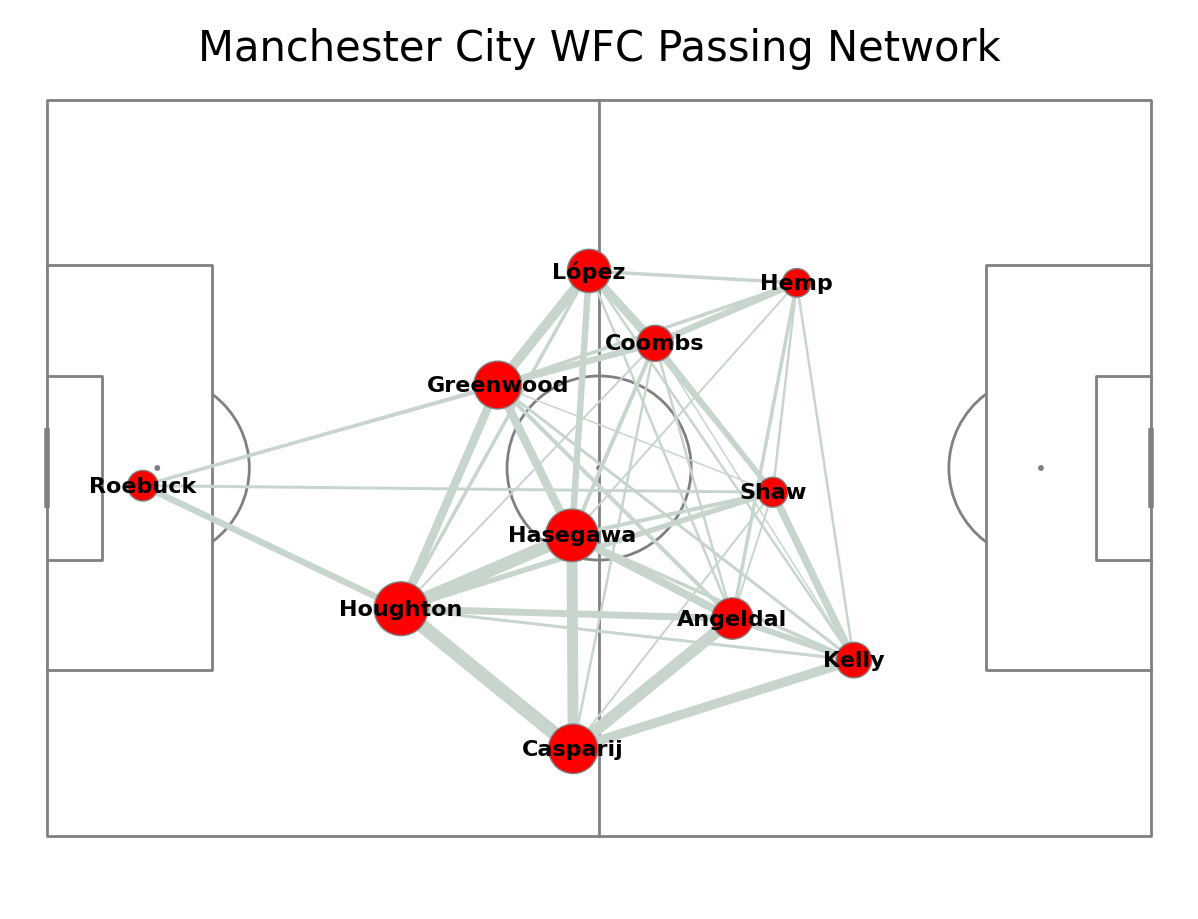

In [30]:
plotting_edges(home_dict)

In [31]:
# home team passing network
df_pass_away = prepare_data_pass(df,team_name=teams_comp[1])

df_pass_edges_away,lines_df_away,scatter_df_away = calculate_edges_width(df_pass_away)

away_dict = \
{
    'df_pass' : df_pass_away,
    'lines_df' : lines_df_away,
    'scatter_df' : scatter_df_away,
    'color': 'blue',
    'team_name' : teams_comp[1]
}

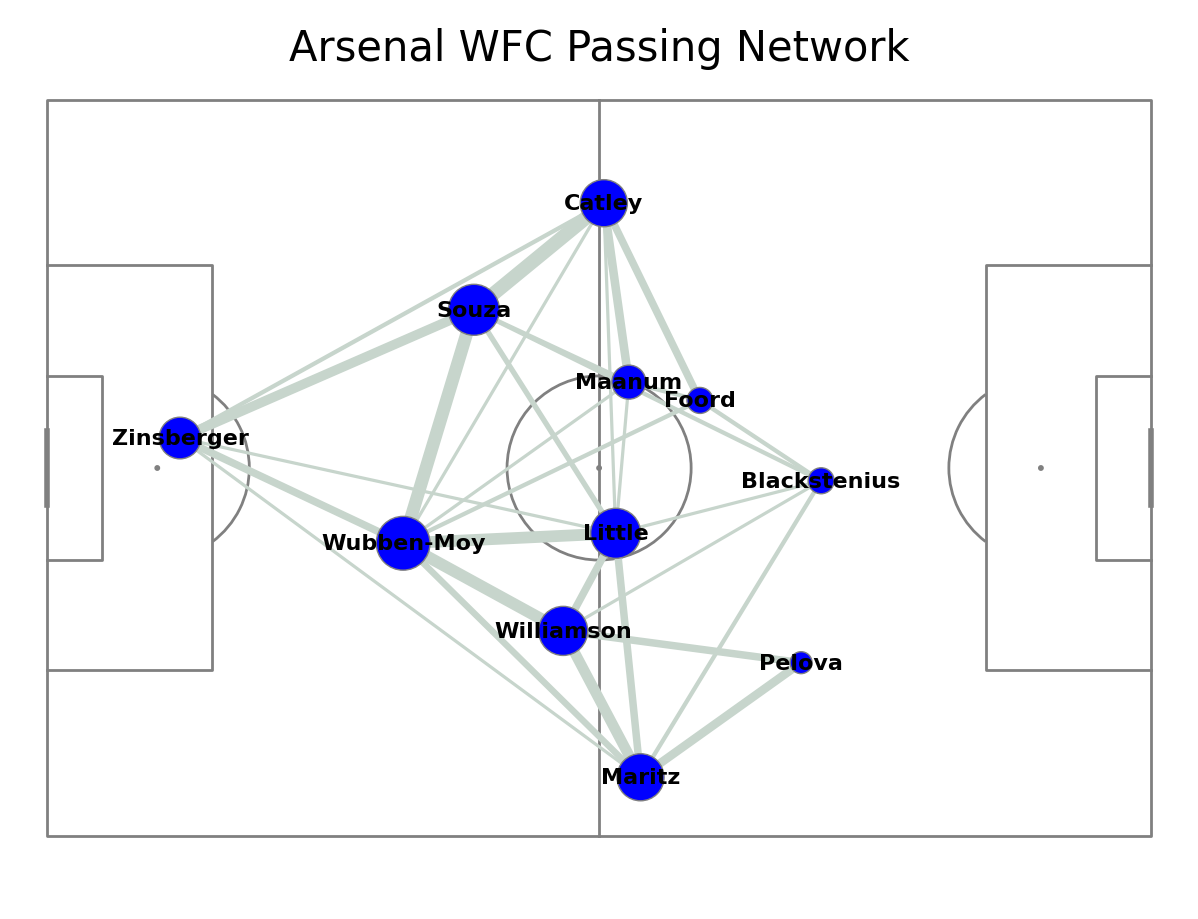

In [32]:
plotting_edges(away_dict)

## Centralisation
To calculate the centralisation index we need to calculate number of passes made by each player. 
Then, we calculate the denominator - the sum of all passes multiplied by (number of players - 1) -> 10
To calculate the numerator we sum the difference between maximal number of successful passes by 1 player
and number of successful passes by each player. We calculate the index dividing the numerator by denominator.

In [33]:
df_pass = df_pass_home.copy()

In [34]:
#calculate number of successful passes by player
no_passes = df_pass.groupby(['player_name']).x.count().reset_index()
no_passes.rename({'x':'pass_count'}, axis='columns', inplace=True)
#find one who made most passes
max_no = no_passes["pass_count"].max() 
#calculate the denominator - 10*the total sum of passes
denominator = 10*no_passes["pass_count"].sum() 
#calculate the nominator
nominator = (max_no - no_passes["pass_count"]).sum()
#calculate the centralisation index
centralisation_index = nominator/denominator
print("Centralisation index is ", centralisation_index)

Centralisation index is  0.06581740976645435


## Passing Network for Forward Passes

In [35]:
df_forward_passes_home = df_pass_home[df_pass_home['x']<df_pass_home['end_x']]

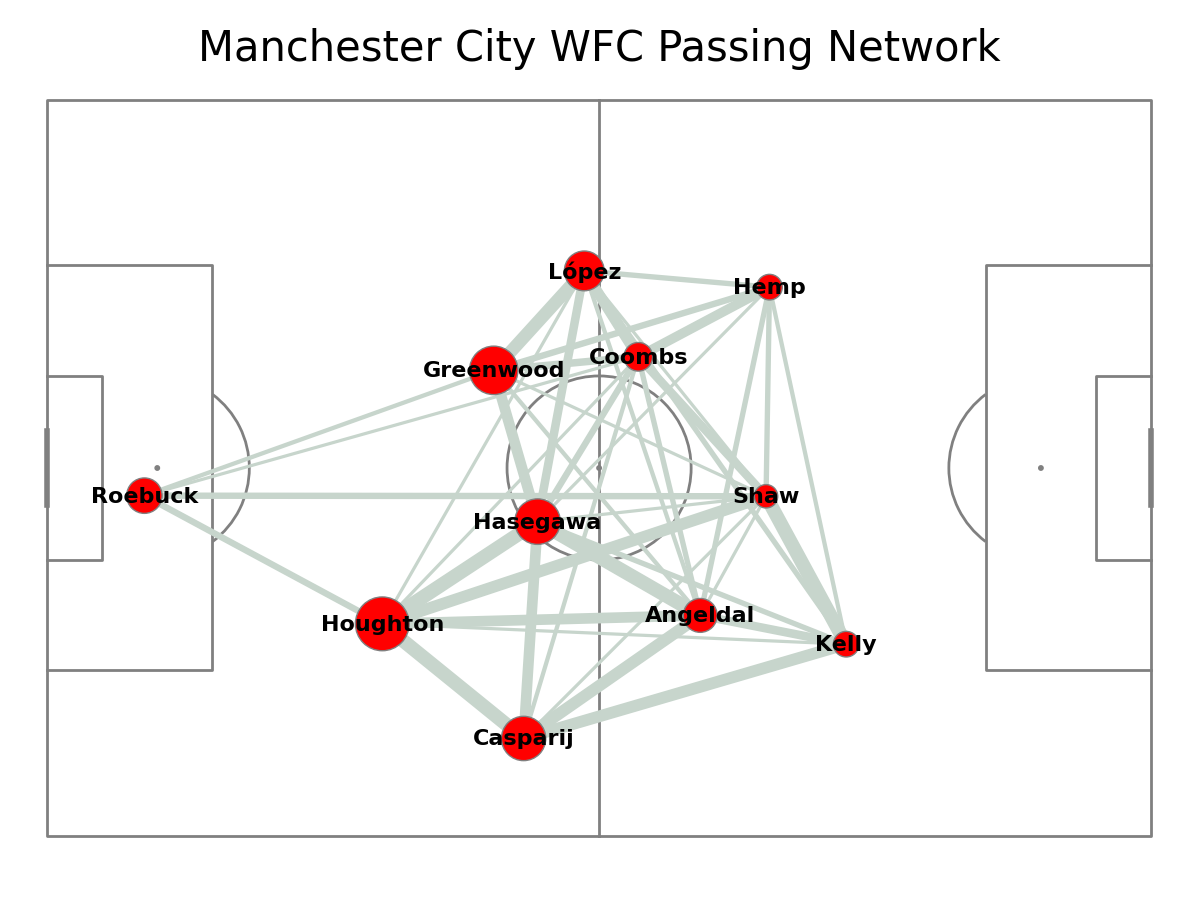

In [36]:
df_pass_edges_forward_home,lines_df_forward_home,scatter_df_forward_home = calculate_edges_width(df_forward_passes_home)

home_dict_forward = \
{
    'df_pass' : df_pass_edges_forward_home,
    'lines_df' : lines_df_forward_home,
    'scatter_df' : scatter_df_forward_home,
    'color': 'red',
    'team_name' : teams_comp[0]
}

plotting_edges(home_dict_forward)

In [37]:
df_forward_passes_away = df_pass_away[df_pass_away['x']<df_pass_away['end_x']]

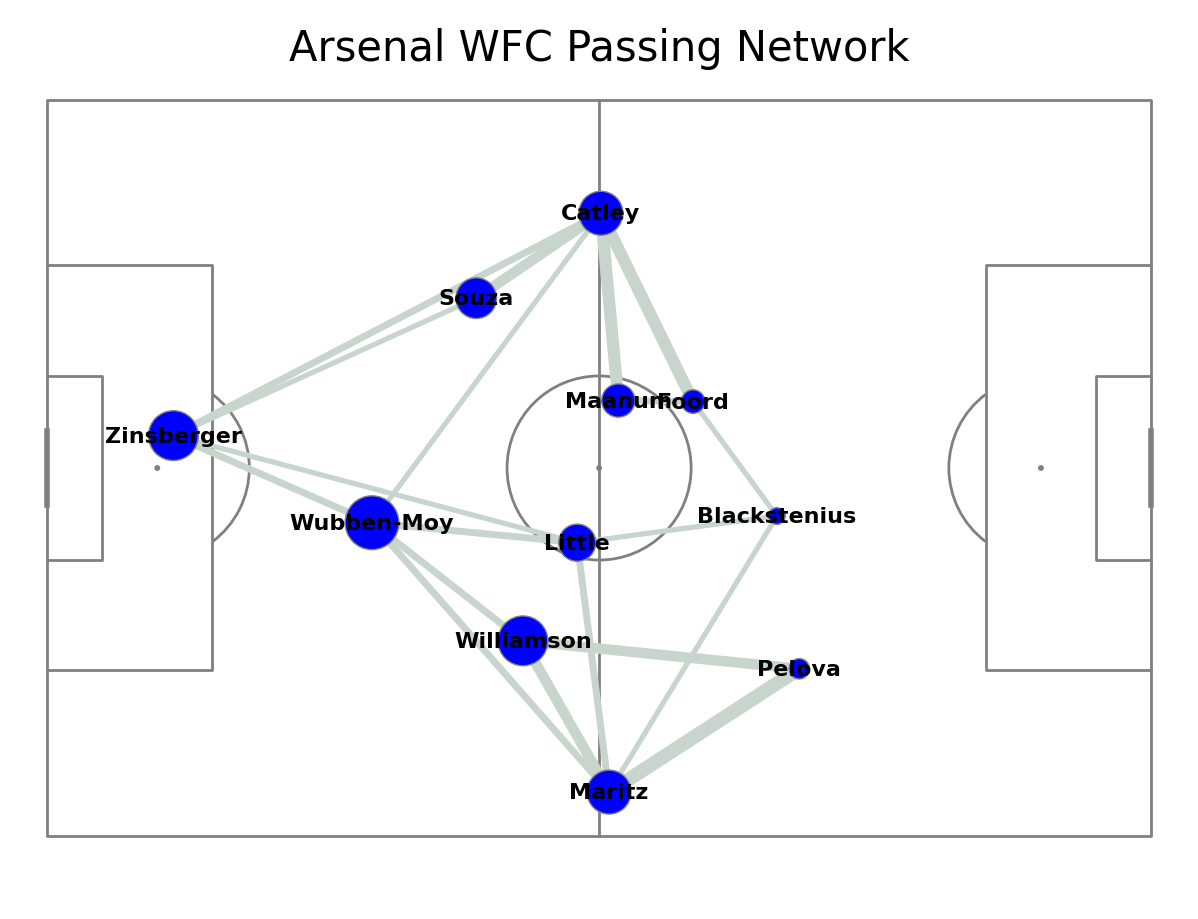

In [38]:
df_pass_edges_forward_away,lines_df_forward_away,scatter_df_forward_away = calculate_edges_width(df_forward_passes_away)

away_dict_forward = \
{
    'df_pass' : df_pass_edges_forward_away,
    'lines_df' : lines_df_forward_away,
    'scatter_df' : scatter_df_forward_away,
    'color': 'blue',
    'team_name' : teams_comp[1]
}

plotting_edges(away_dict_forward)

## Plotting multiple pass maps on one figure

In [39]:
team_name = teams_comp[0]
sub = True
#check for index of first sub
if sub:
    sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == team_name].iloc[0]["index"]

#make df with successfull passes by Manchester City until the first substitution
if sub:
    mask_mancity = (df['type_name'] == 'Pass')\
    & (df['team_name']==team_name) \
    & (df.index < sub) \
    &(df['substitution_replacement_name'].isnull())\
    &(~df['pass_recipient_name'].isnull())
else:
    mask_mancity = (df['type_name'] == 'Pass')\
    & (df['team_name']==team_name) \
    &(df['substitution_replacement_name'].isnull())\
    &(~df['pass_recipient_name'].isnull()) 

#taking necessary columns
df_pass_details = df.loc[mask_mancity, ['location','pass_end_location','player_name','pass_recipient_name']]


In [110]:
#prepare the dataframe of passes by the team that were no-throw ins
def prepare_passes_each_player(df,team_name):
    mask_team = (df['type_name'] == 'Pass') & (df['team_name'] == team_name)
    #taking necessary columns
    df_pass_details = df.loc[mask_team, ['location','pass_end_location','player_name','pass_recipient_name']]
    #get the list of all players who made a pass
    names = df_pass_details['player_name'].unique()

    df_pass_details['x'] = [axes[0] for axes in df_pass_details['location'].values]
    df_pass_details['y'] = [axes[1] for axes in df_pass_details['location'].values]

    df_pass_details['end_x'] = [axes[0] for axes in df_pass_details['pass_end_location'].values]
    df_pass_details['end_y'] = [axes[1] for axes in df_pass_details['pass_end_location'].values]

    df_passes = df_pass_details[['x', 'y', 'end_x', 'end_y','player_name','pass_recipient_name']]
    return df_passes 

#draw 4x4 pitches
def plot_pitch_passes(df_passes,home_team,away_team):
    pitch = Pitch(line_color='black', pad_top=20)
    names = df_passes['player_name'].unique()
    fig, axs = pitch.grid(ncols = 4, nrows = int(len(names)/4), grid_height=0.85, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0.04, endnote_space=0.01)

    #for each player
    for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
        # if name == 'Lauren Hemp':
        #     import pdb;pdb.set_trace()
        # #put player name over the plot
        ax.text(60, -10, name,
                ha='center', va='center', fontsize=14)
        #take only passes by this player
        player_df = df_passes.loc[df_passes["player_name"] == name]
        #scatter
        pitch.scatter(player_df.x, player_df.y, alpha = 0.2, s = 50, color = "blue", ax=ax)
        #plot arrow
        pitch.arrows(player_df.x, player_df.y,
                player_df.end_x, player_df.end_y, color = "blue", ax=ax, width=1)

    #We have more than enough pitches - remove them
    for ax in axs['pitch'][-1, 16 - len(names):]:
        ax.remove()

    #Another way to set title using mplsoccer
    axs['title'].text(0.5, 0.5, f'{teams_comp[0]} passes against {teams_comp[1]}', ha='center', va='center', fontsize=30)
    plt.show()

In [97]:
df_passes['player_name'].unique()

array(['Khadija Monifa Shaw', 'Yui Hasegawa', 'Stephanie Houghton',
       'Alex Greenwood', 'Laura Coombs', 'Laia Aleixandri',
       'Kerstin Yasmijn Casparij', 'Ellie Roebuck',
       'Ingrid Filippa Angeldal', 'Chloe Kelly', 'Lauren Hemp'],
      dtype=object)

In [98]:
df_passes_each_player = prepare_passes_each_player(df,teams_comp[0])

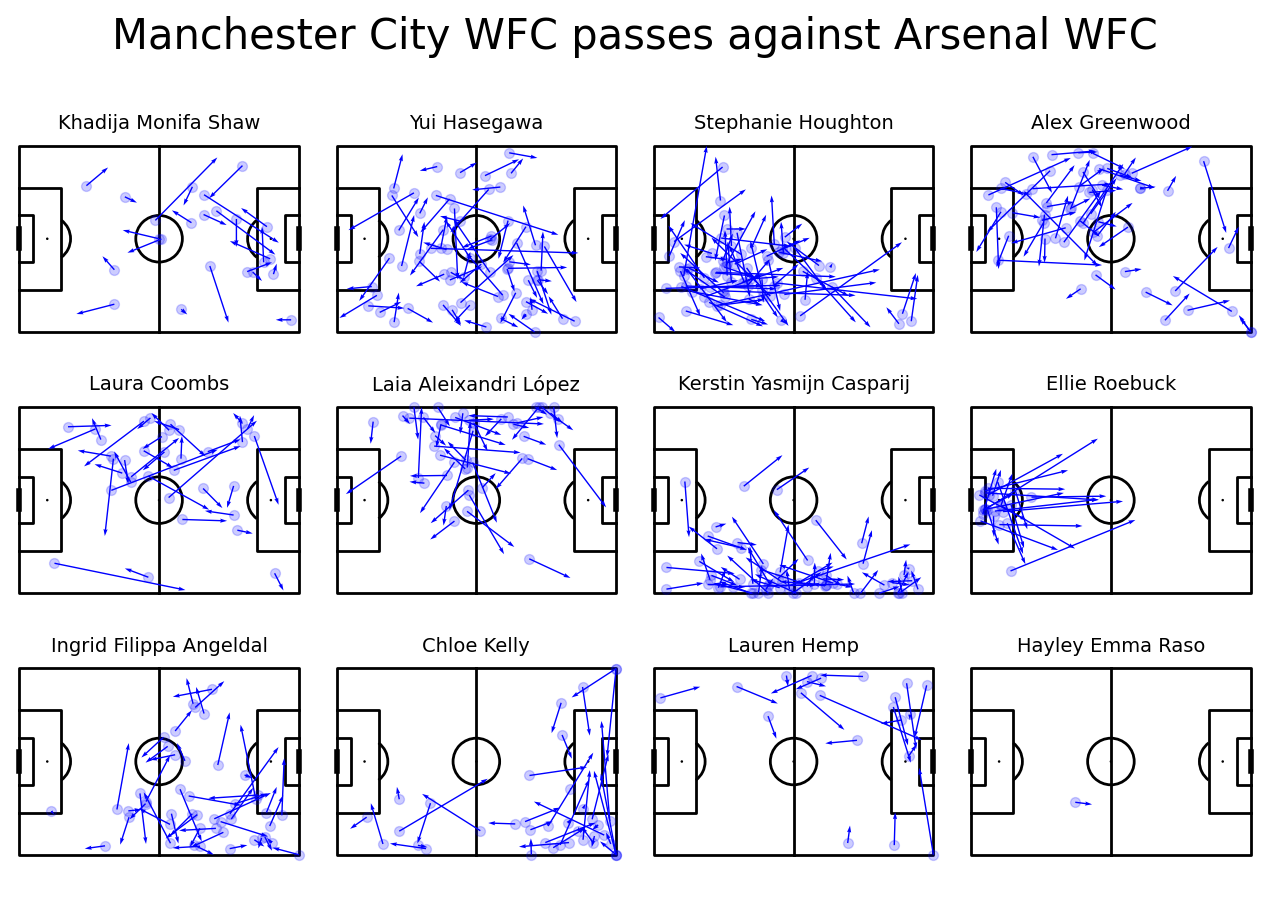

In [111]:
plot_pitch_passes(df_passes_each_player,home_team=teams_comp[0],away_team=teams_comp[1])

## Finding danger passes
- Look for the passes 15 seconds before a shot.

In [43]:
#declare an empty dataframe
def danger_passes_all_matches():
    danger_passes = pd.DataFrame()
    for idx in match_ids:
        #open the event data from this game
        df = parser.event(idx)[0]
        for period in [1, 2]:
            #keep only accurate passes by England that were not set pieces in this period
            mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
            #keep only necessary columns
            passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]
            #keep only Shots by England in this period
            mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
            #keep only necessary columns
            shots = df.loc[mask_shot, ["minute", "second"]]
            #convert time to seconds
            shot_times = shots['minute']*60+shots['second']
            shot_window = 15
            #find starts of the window
            shot_start = shot_times - shot_window
            #condition to avoid negative shot starts
            shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
            #convert to seconds
            pass_times = passes['minute']*60+passes['second']
            #check if pass is in any of the windows for this half
            pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

            #keep only danger passes
            danger_passes_period = passes.loc[pass_to_shot]
            #concatenate dataframe with a previous one to keep danger passes from the whole tournament
            danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

In [44]:
#taking necessary columns
def get_mask_df(df,mask_pass):
    df_pass_details = df.loc[mask_pass, ['location','pass_end_location','player_name','pass_recipient_name','minute', 'second']]

    df_pass_details['x'] = [axes[0] for axes in df_pass_details['location'].values]
    df_pass_details['y'] = [axes[1] for axes in df_pass_details['location'].values]

    df_pass_details['end_x'] = [axes[0] for axes in df_pass_details['pass_end_location'].values]
    df_pass_details['end_y'] = [axes[1] for axes in df_pass_details['pass_end_location'].values]

    df_pass = df_pass_details[['x', 'y', 'end_x', 'end_y','player_name','pass_recipient_name','minute', 'second']]
    return df_pass

In [45]:
period = 1
#keep only accurate passes by England that were not set pieces in this period
danger_passes = pd.DataFrame()
mask_pass = \
(df['team_name'] == teams_comp[0]) \
& (df['type_name'] == "Pass") \
& (~df['pass_recipient_name'].isnull()) \
& (df['period'] == period) \
# & (df.sub_type_name.isnull())

#keep only necessary columns
passes = get_mask_df(df,mask_pass)

#keep only Shots by England in this period
mask_shot = (df['team_name'] == teams_comp[0]) & (df['type_name'] == "Shot") & (df.period == period)

#keep only necessary columns
shots = df.loc[mask_shot, ["minute", "second"]]

#convert time to seconds
shot_times = shots['minute']*60+shots['second']
shot_window = 15
#find starts of the window
shot_start = shot_times - shot_window

#condition to avoid negative shot starts
shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
#convert to seconds
pass_times = passes['minute']*60+passes['second']
#check if pass is in any of the windows for this half
pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

#keep only danger passes
danger_passes_period = passes.loc[pass_to_shot]

In [46]:
danger_passes = pd.concat([danger_passes,danger_passes_period])

## Plotting location of danger passes

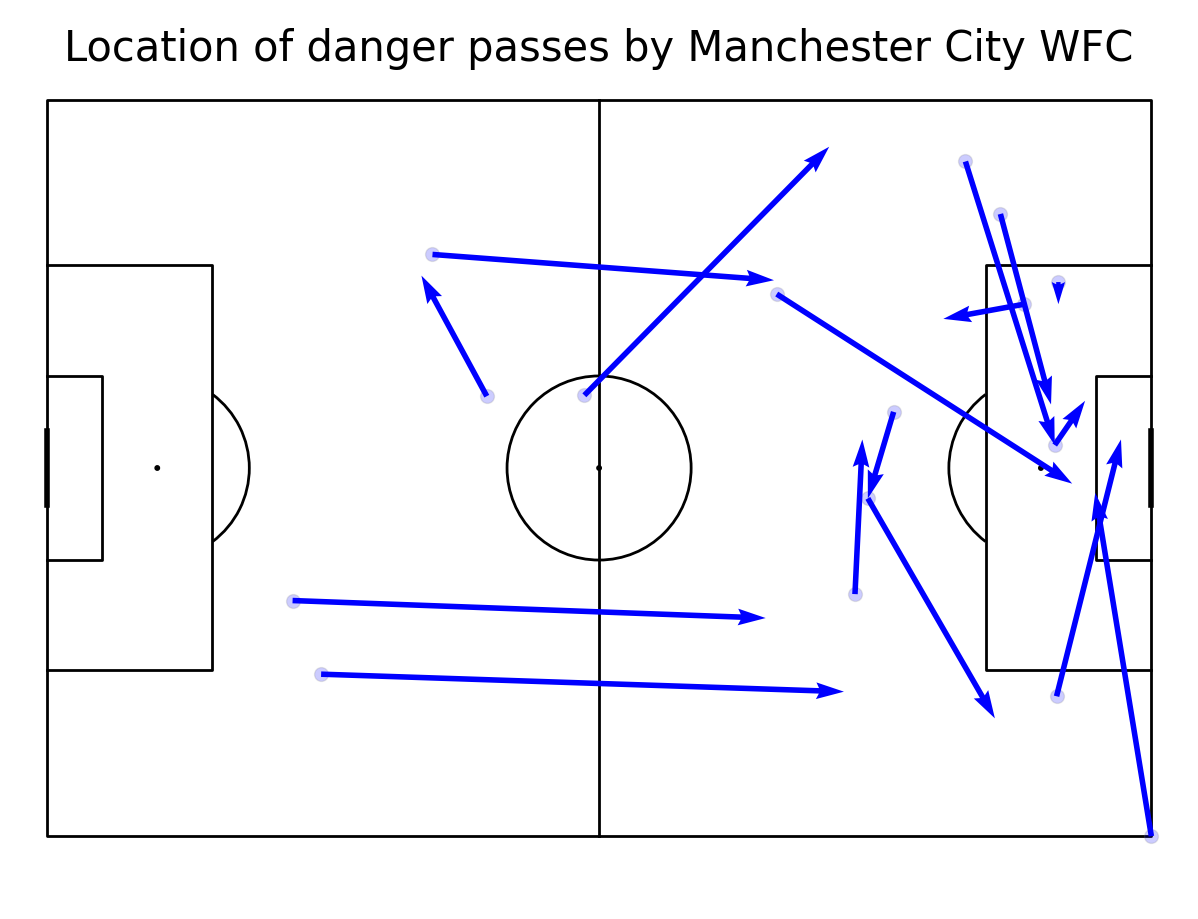

In [47]:
#plot pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])
#uncomment it to plot arrows
pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])
#add title
fig.suptitle('Location of danger passes by ' + teams_comp[0], fontsize = 30)
plt.show()

## Making a heat map
- Calculate the number of passes in each bin using bin_statistic method
- Normalize number of passes by number of games
- Plot a heat map

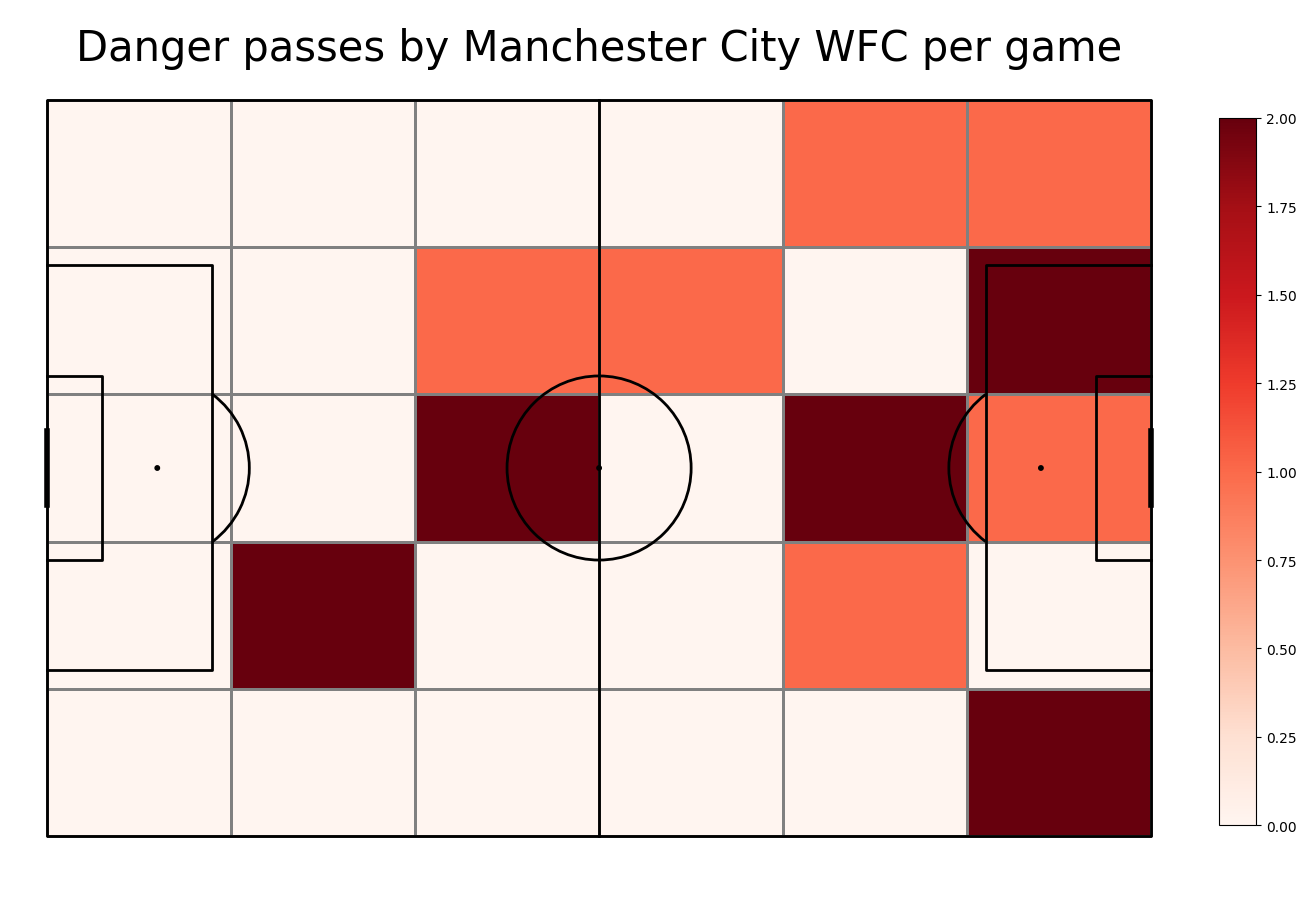

In [48]:
no_games = 1
team = teams_comp[0]
#plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#get the 2D histogram
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
#normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)
plt.show()

## Making a diagram of most involved players

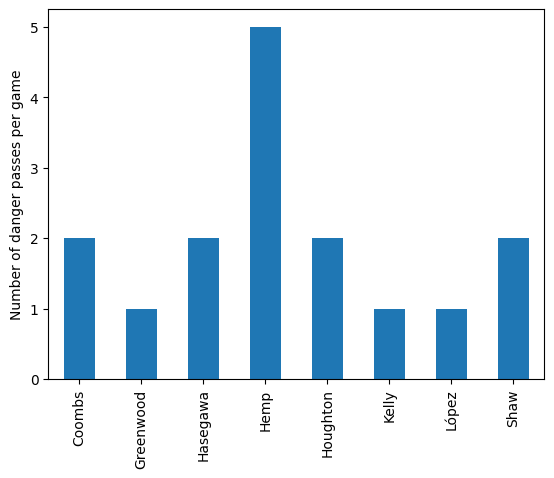

In [49]:
#keep only surnames
danger_passes["player_name"] = danger_passes["player_name"].apply(lambda x: str(x).split()[-1])
#count passes by player and normalize them
pass_count = danger_passes.groupby(["player_name"]).x.count()/no_games
#make a histogram
ax = pass_count.plot.bar(pass_count)
#make legend
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show()

## Case study: attacking play
### Summarising attacking play
- By looking at the passes we can find out where players are creating problems for the opposition
- The darker the area the more passes he has made per 90 minutes. The blue arrows show the average direction of his passes.

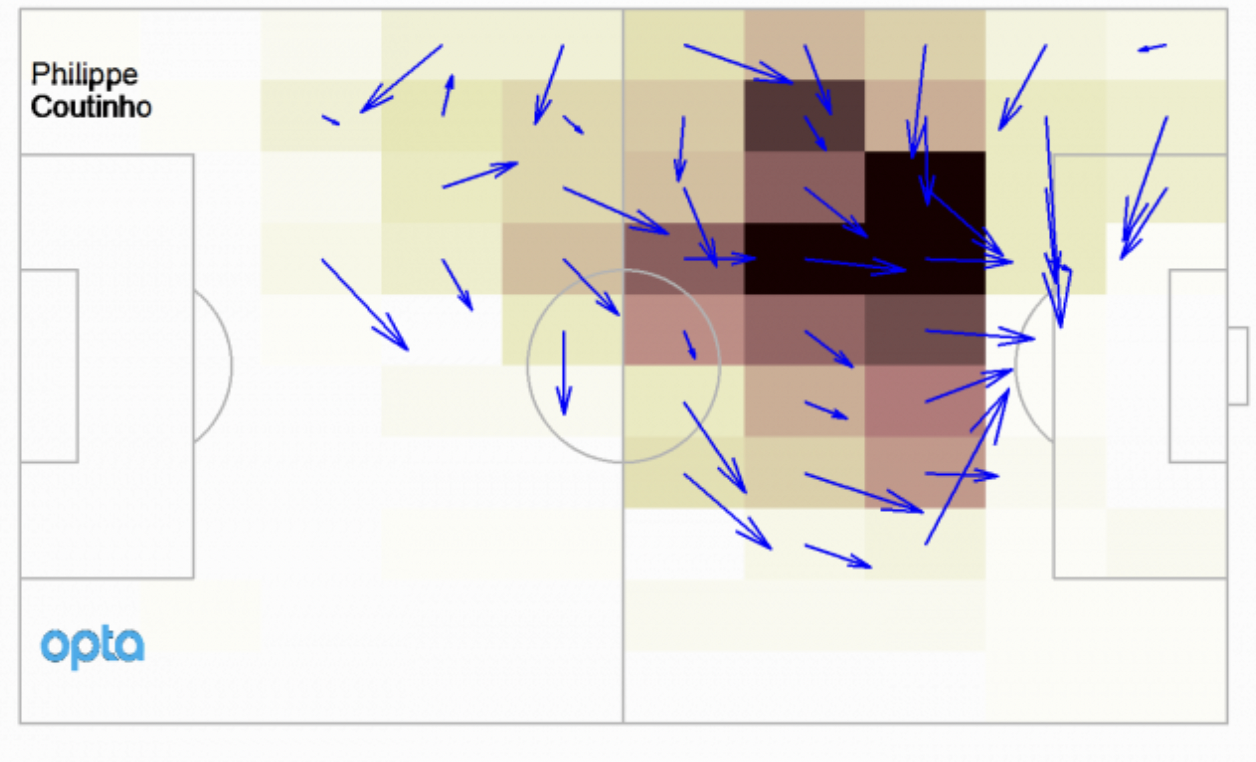

### Thinks to think about
- Heat maps are spatial histograms. Each square on the heat map shows the number of passes made by the player from that square.
- The ‘hotter’ the square, the more passes made.
- For example, we can look at where passes are received. This is a good way of assessing strikers, who make fewer passes but are often on the end of them. 
- Defensive heat maps can also be made by looking at where players recover the ball.

## Case study: 5-second rule (KPI)

### Getting the ball back
- Attributed to Pep Guardiola Barcelona’s team of 2008-12
- “if you lose the ball when attacking then regain it within five seconds, if not fall back in to a more traditional defence”
- It is important to also take in to account of position on the field.
- The ‘five-second-rule’ is mainly used in **attack**, so **regains in the final third are more important (and often more dangerous) than in the team’s own half**
- **KPI: how often do we get the ball back within 5 seconds after we lose it.**

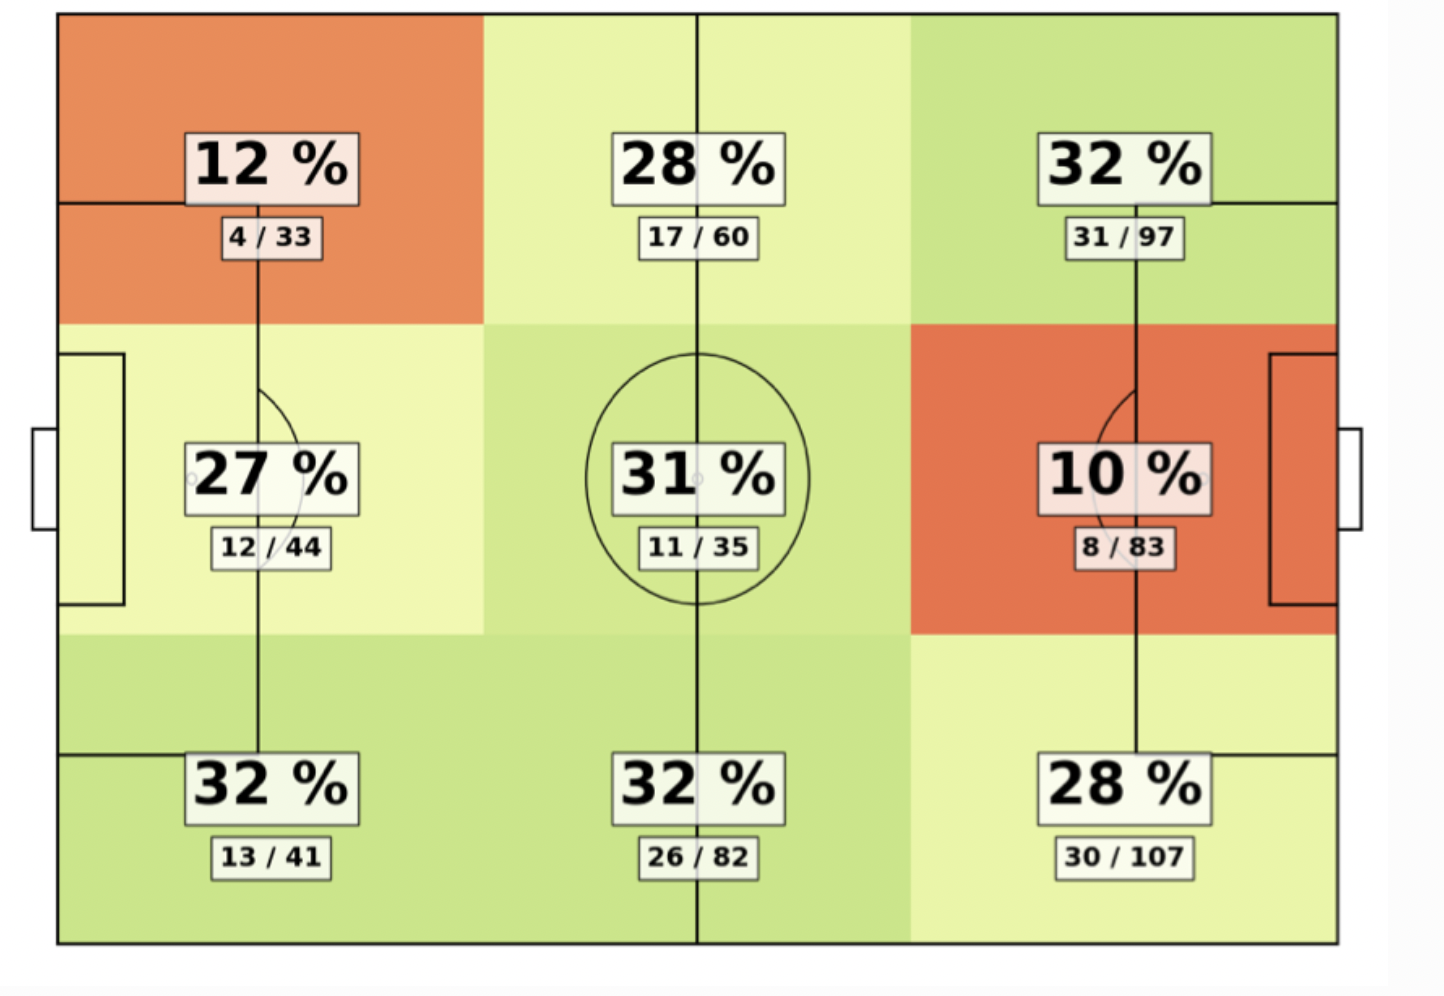

- The percent is the proportion of times that Hammarby recovered the ball after they lost it in each section of the pitch. 
- The key to creating a good KPI is finding something that combines the practices of grassroots football and the culture of measurement and prediction.
- When creating a KPI you should ask yourself the following question: **why are you collecting a KPI about a football team?**
- A measurement should be something which helps everyone move toward, an attempt to capture something that the whole organisation agrees it is worth measuring

## Graph Visualization from Total Passes

### Step 1: Set text information

In [115]:
plot_name = "statsbomb_match: {0} vs {1}".format(teams_comp[1], teams_comp[0])

opponent_team = [x for x in df_events.team_name.unique() if x != team_name][0]
plot_title ="{0}'s passing network against {1} (StatsBomb eventing data)".format(team_name, opponent_team)

plot_legend = "Location: pass origin\nSize: number of passes\nColor: number of passes"

### Step 2: Prepare data for Graph Visualization

In [154]:
def _statsbomb_to_point(location, max_width=120, max_height=80, pos=0):
    '''
    Convert a point's coordinates from a StatsBomb's range to 0-1 range.
    '''
    if pos == 0:
        return np.round(location / max_width,2)
    else:
        return np.round(1-(location / max_height),2)

### Step 3: Plot passing network (Total passes)

In [183]:
from visualization.passing_network import draw_pitch, draw_pass_map
import matplotlib.pyplot as plt

def plot_passing_network_graph(df,plot_title,plot_legend):
    graph_passes = df.copy()  
    graph_passes['origin_pos_x'] = graph_passes.x.apply(lambda x: _statsbomb_to_point(x,pos=0))
    graph_passes['origin_pos_y'] = graph_passes.y.apply(lambda x: _statsbomb_to_point(x,pos=1))
    player_position = graph_passes.groupby("player_name").agg({"origin_pos_x": "mean", "origin_pos_y": "mean"})
    player_pass_count = graph_passes.groupby("player_name").size().to_frame("num_passes")
    player_pass_value = graph_passes.groupby("player_name").size().to_frame("pass_value")

    graph_passes["pair_key"] = graph_passes.apply(lambda x: "_".join([x["player_name"], x["pass_recipient_name"]]), axis=1)
    pair_pass_count = graph_passes.groupby("pair_key").size().to_frame("num_passes")
    pair_pass_value = graph_passes.groupby("pair_key").size().to_frame("pass_value")
    
    ax = draw_pitch()
    ax = draw_pass_map(ax, player_position, player_pass_count, player_pass_value,
                  pair_pass_count, pair_pass_value, plot_title, plot_legend)


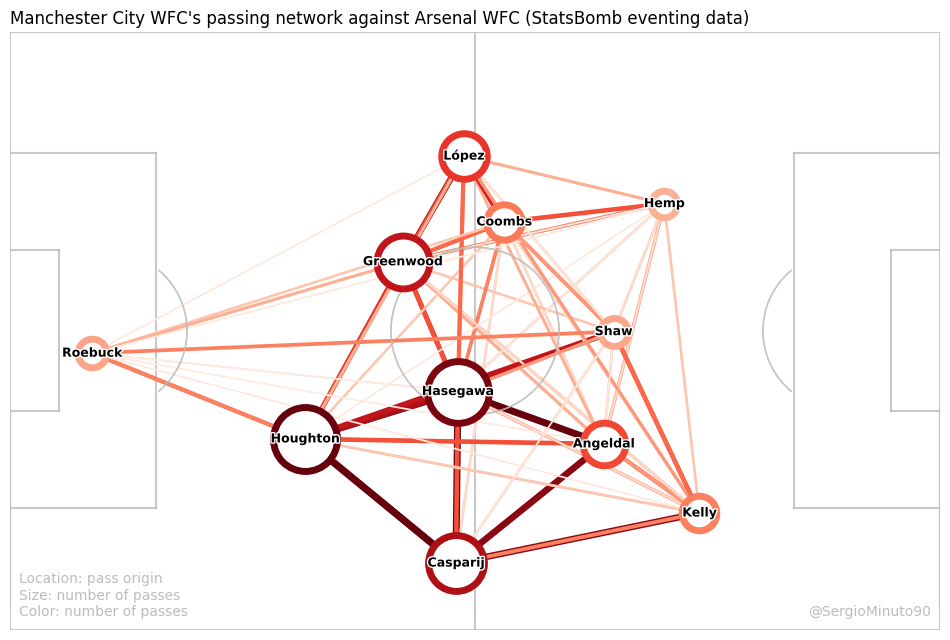

In [184]:
plot_passing_network_graph(home_dict['df_pass'],plot_title,plot_legend)

## Graph Visualization from Eigenvector Centrality

In [186]:
def get_passes_matrix(df_passes, players):
    # Get in Matrix format
    player_pass_count = df_passes.groupby(["player_name_1","player_name_2"]).size().to_frame("num_passes").reset_index()
    player_pass_count = player_pass_count.pivot_table(values='num_passes', index="player_name_1", columns='player_name_2')

    # Get passing matrix for all players in team (all no matter if did not play or did not pass)
    passing_matrix = pd.DataFrame(player_pass_count,columns=players,index=players).fillna(0).astype(int)
    return passing_matrix   

In [206]:
def plot_passing_network_eigenvector(df,plot_title,plot_legend):
    graph_passes = df.copy()
    
    graph_passes.rename(columns={'player_name':'player_name_1','pass_recipient_name':'player_name_2'},inplace=True)

    players = graph_passes['player_name_1'].unique()
    matrix_all = get_passes_matrix(graph_passes,players) 

    # Get graphs
    graph_passes_all = nx.from_pandas_adjacency(matrix_all, create_using = nx.DiGraph)

    # Get centralities for each graph
    eigen_cent_all = list(nx.eigenvector_centrality(graph_passes_all,weight='weight').values())

    # Get num of passes done and received
    passes_done_all = matrix_all.sum(axis = 1)
    passes_received_all = matrix_all.sum()

    # Get the stats for that team in the match
    stats_match = pd.DataFrame(list(zip(players,passes_done_all,passes_received_all,
                                        eigen_cent_all)), 
                               columns = ['Player','Passes done All','Passes received All','eigen_cent_all'])


    graph_passes['pair_key'] = graph_passes['player_name_1']+'_'+graph_passes['player_name_2']

    graph_passes['origin_pos_x'] = graph_passes.x.apply(lambda x: _statsbomb_to_point(x,pos=0))
    graph_passes['origin_pos_y'] = graph_passes.y.apply(lambda x: _statsbomb_to_point(x,pos=1))
    player_position = graph_passes.rename(columns={'player_name_1':'player_name'}).groupby('player_name').agg({"origin_pos_x": "mean", "origin_pos_y": "mean"})

    player_pass_count = pd.DataFrame()
    player_pass_count['num_passes'] = stats_match['eigen_cent_all']
    player_pass_count.index = stats_match.rename(columns={'Player':'player_name'})['player_name']

    player_pass_value = graph_passes.groupby("player_name_1").size().to_frame("pass_value")

    pair_pass_count = graph_passes.groupby("pair_key").size().to_frame("num_passes")
    pair_pass_value = graph_passes.groupby("pair_key").size().to_frame("pass_value")
    
    ax = draw_pitch()
    ax = draw_pass_map(ax, player_position, player_pass_count, player_pass_value,
                  pair_pass_count, pair_pass_value, plot_title, plot_legend,debug=False)

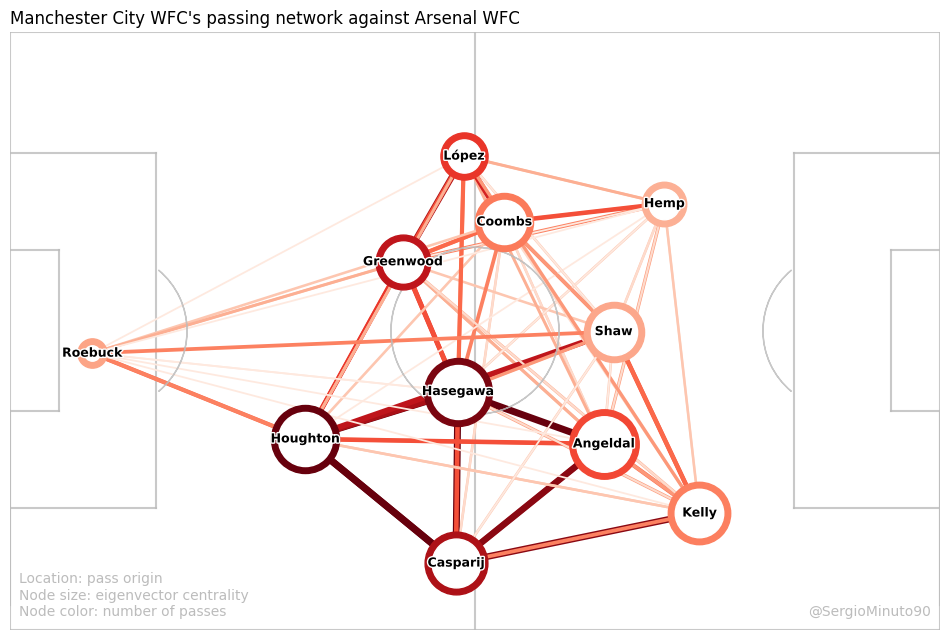

In [207]:
plot_title =f"{teams_comp[0]}'s passing network against {teams_comp[1]}"
plot_legend = "Location: pass origin\nNode size: eigenvector centrality\nNode color: number of passes"
plot_passing_network_eigenvector(home_dict['df_pass'],plot_title=plot_title,plot_legend=plot_legend)

## Lost and Regain passes
1. Identify all the balls that our team lost during the match (df['interception.name'])
2. Identify which lost ball were regained within 5 secs

In [50]:
df['type_name'].value_counts()

Pass                 962
Ball Receipt*        925
Carry                806
Pressure             360
Ball Recovery        111
Duel                  65
Dribble               46
Interception          44
Block                 41
Clearance             41
Goal Keeper           31
Dribbled Past         28
Miscontrol            27
Dispossessed          23
Foul Committed        22
Foul Won              22
Shot                  22
Injury Stoppage        9
50/50                  8
Substitution           6
Referee Ball-Drop      6
Half Start             4
Half End               4
Player On              4
Player Off             4
Starting XI            2
Error                  2
Offside                1
Tactical Shift         1
Bad Behaviour          1
Shield                 1
Name: type_name, dtype: int64

In [51]:
df[(df['type_name']=='Pressure')].head()

id  index  period     timestamp  minute  \
14  c5cfd071-adc7-455f-a7a9-ed7b7a9da9e4     15       1  00:00:07.979       0   
26  c57a1294-5d54-426e-a35b-2ff7188c95ed     27       1  00:00:14.721       0   
42  68917175-3dc1-4644-92b6-a7b749c2bdda     43       1  00:00:35.822       0   
52  f82ee0e3-0a20-480c-8c0c-c7e5162f8644     53       1  00:00:43.667       0   
56  71fe66e7-bab1-4a0a-8907-e59015b1bfc4     57       1  00:00:45.026       0   

    second  possession  obv_for_after  obv_for_before  obv_for_net  ...  \
14       7           2            NaN             NaN          NaN  ...   
26      14           2            NaN             NaN          NaN  ...   
42      35           3            NaN             NaN          NaN  ...   
52      43           3            NaN             NaN          NaN  ...   
56      45           3            NaN             NaN          NaN  ...   

    substitution_replacement_name  pass_inswinging  foul_committed_card_id  \
14                            NaN              NaN                     NaN   
26                            NaN              NaN                     NaN   
42                            NaN              NaN                     NaN   
52                            NaN              NaN                     NaN   
56                            NaN              NaN                     NaN   

    foul_committed_card_name  bad_behaviour_card_id  bad_behaviour_card_name  \
14                       NaN                    NaN                      NaN   
26                       NaN                    NaN                      NaN   
42                       NaN                    NaN                      NaN   
52                       NaN                    NaN                      NaN   
56                       NaN                    NaN                      NaN   

   pass_miscommunication  pass_cut_back dribble_overrun  pass_outswinging  
14                   NaN            NaN             NaN               NaN  
26                   NaN            NaN             NaN               NaN  
42                   NaN            NaN             NaN               NaN  
52                   NaN            NaN             NaN               NaN  
56                   NaN            NaN             NaN               NaN  

[5 rows x 127 columns]

In [52]:
df[(df['team_name']==teams_comp[0]) & (df['type_name']=='Ball Recovery')].shape

(54, 127)

In [53]:
df[(df['team_name']==teams_comp[1]) & (df['type_name']=='Block') ].head()

id  index  period     timestamp  \
117  6bb35d54-6c55-47a8-9723-faa2b0b2196f    118       1  00:02:09.679   
279  1733df8c-f7da-4d15-b2db-19484fecb54f    280       1  00:05:42.516   
395  13235f82-8b05-40d8-81a2-9653dbbdafa3    396       1  00:08:05.545   
534  8602c4e6-dfda-4c5a-95ae-c55c3ccd17d7    535       1  00:11:04.299   
652  6a129229-30d6-492e-aae2-f2f69197a306    653       1  00:13:32.976   

     minute  second  possession  obv_for_after  obv_for_before  obv_for_net  \
117       2       9           6       0.007819        0.008448    -0.000629   
279       5      42          11       0.008291        0.008470    -0.000179   
395       8       5          17       0.009275        0.009563    -0.000288   
534      11       4          29       0.008691        0.009513    -0.000822   
652      13      32          33       0.034115        0.015136     0.018979   

     ...  substitution_replacement_name  pass_inswinging  \
117  ...                            NaN              NaN   
279  ...                            NaN              NaN   
395  ...                            NaN              NaN   
534  ...                            NaN              NaN   
652  ...                            NaN              NaN   

     foul_committed_card_id  foul_committed_card_name  bad_behaviour_card_id  \
117                     NaN                       NaN                    NaN   
279                     NaN                       NaN                    NaN   
395                     NaN                       NaN                    NaN   
534                     NaN                       NaN                    NaN   
652                     NaN                       NaN                    NaN   

     bad_behaviour_card_name pass_miscommunication  pass_cut_back  \
117                      NaN                   NaN            NaN   
279                      NaN                   NaN            NaN   
395                      NaN                   NaN            NaN   
534                      NaN                   NaN            NaN   
652                      NaN                   NaN            NaN   

    dribble_overrun  pass_outswinging  
117             NaN               NaN  
279             NaN               NaN  
395             NaN               NaN  
534             NaN               NaN  
652             NaN               NaN  

[5 rows x 127 columns]

In [54]:
df[(df['team_name']==teams_comp[1]) & (df['type_name']=='Ball Recovery') ].shape

(57, 127)

In [55]:
df[(df['minute']==5) & (df['team_name']==teams_comp[1]) & (df['possession_team_name']==teams_comp[1])].head()

id  index  period     timestamp  \
280  cc228a6a-5f11-4269-ae9e-5cd91ab57328    281       1  00:05:43.926   
281  ca4d1765-5c6c-479a-ac02-2fd1a3150543    282       1  00:05:43.926   
283  3701b1a2-8180-4fc2-9f05-e8a2c0c1652c    284       1  00:05:46.659   
285  e7740d2a-6498-4d85-813a-e8ecc2a560fa    286       1  00:05:48.069   
286  ce19b77f-e732-42eb-9739-252204cae6f8    287       1  00:05:48.069   

     minute  second  possession  obv_for_after  obv_for_before  obv_for_net  \
280       5      43          12            NaN             NaN          NaN   
281       5      43          12       0.012122        0.008291     0.003832   
283       5      46          12       0.009920        0.012122    -0.002202   
285       5      48          12            NaN             NaN          NaN   
286       5      48          12       0.011102        0.009920     0.001182   

     ...  substitution_replacement_name  pass_inswinging  \
280  ...                            NaN              NaN   
281  ...                            NaN              NaN   
283  ...                            NaN              NaN   
285  ...                            NaN              NaN   
286  ...                            NaN              NaN   

     foul_committed_card_id  foul_committed_card_name  bad_behaviour_card_id  \
280                     NaN                       NaN                    NaN   
281                     NaN                       NaN                    NaN   
283                     NaN                       NaN                    NaN   
285                     NaN                       NaN                    NaN   
286                     NaN                       NaN                    NaN   

     bad_behaviour_card_name pass_miscommunication  pass_cut_back  \
280                      NaN                   NaN            NaN   
281                      NaN                   NaN            NaN   
283                      NaN                   NaN            NaN   
285                      NaN                   NaN            NaN   
286                      NaN                   NaN            NaN   

    dribble_overrun  pass_outswinging  
280             NaN               NaN  
281             NaN               NaN  
283             NaN               NaN  
285             NaN               NaN  
286             NaN               NaN  

[5 rows x 127 columns]

In [56]:
df[(df['minute']==5) & (df['type_name']=='Pass') & (df['team_name']==teams_comp[0])].head()

id  index  period     timestamp  \
231  983ee20e-5680-4a31-9bac-e869107baed7    232       1  00:05:00.154   
233  baf70198-6fe1-43fa-a887-e2f09bdfd6a6    234       1  00:05:00.983   
238  7bbd2389-faf0-464d-a4c6-90d665022c4f    239       1  00:05:02.649   
242  98671242-fca3-4f64-bc4d-62aaf87541e0    243       1  00:05:05.997   
250  898ce0d0-5633-460a-b197-307415001b71    251       1  00:05:12.944   

     minute  second  possession  obv_for_after  obv_for_before  obv_for_net  \
231       5       0          11       0.015038        0.013382     0.001656   
233       5       0          11       0.013377        0.015038    -0.001661   
238       5       2          11       0.021465        0.014966     0.006499   
242       5       5          11       0.011011        0.025405    -0.014394   
250       5      12          11       0.024342        0.054995    -0.030653   

     ...  substitution_replacement_name  pass_inswinging  \
231  ...                            NaN              NaN   
233  ...                            NaN              NaN   
238  ...                            NaN              NaN   
242  ...                            NaN              NaN   
250  ...                            NaN              NaN   

     foul_committed_card_id  foul_committed_card_name  bad_behaviour_card_id  \
231                     NaN                       NaN                    NaN   
233                     NaN                       NaN                    NaN   
238                     NaN                       NaN                    NaN   
242                     NaN                       NaN                    NaN   
250                     NaN                       NaN                    NaN   

     bad_behaviour_card_name pass_miscommunication  pass_cut_back  \
231                      NaN                   NaN            NaN   
233                      NaN                   NaN            NaN   
238                      NaN                   NaN            NaN   
242                      NaN                   NaN            NaN   
250                      NaN                   NaN            NaN   

    dribble_overrun  pass_outswinging  
231             NaN               NaN  
233             NaN               NaN  
238             NaN               NaN  
242             NaN               NaN  
250             NaN               NaN  

[5 rows x 127 columns]

In [58]:
df[(df['play_pattern_name']=='Regular Play')\
   & (df['team_name']==teams_comp[0])].head()

id  index  period     timestamp  minute  \
0   5ab3a8e3-e6e1-4a94-b057-57b2301abac5      1       1  00:00:00.000       0   
2   7b3793be-f0aa-40b5-aedf-e2ec45e43069      3       1  00:00:00.000       0   
40  b9cf5a76-1ae3-4715-9825-ac0822cac2dd     41       1  00:00:34.454       0   
43  270fe2a8-3d10-47ef-9d30-3db2a8a3c1fc     44       1  00:00:36.169       0   
44  185da75f-0ef5-42b9-82a4-304dadaa0db3     45       1  00:00:38.614       0   

    second  possession  obv_for_after  obv_for_before  obv_for_net  ...  \
0        0           1            NaN             NaN          NaN  ...   
2        0           1            NaN             NaN          NaN  ...   
40      34           3            NaN             NaN          NaN  ...   
43      36           3       0.009959        0.009398     0.000561  ...   
44      38           3            NaN             NaN          NaN  ...   

    substitution_replacement_name  pass_inswinging  foul_committed_card_id  \
0                             NaN              NaN                     NaN   
2                             NaN              NaN                     NaN   
40                            NaN              NaN                     NaN   
43                            NaN              NaN                     NaN   
44                            NaN              NaN                     NaN   

    foul_committed_card_name  bad_behaviour_card_id  bad_behaviour_card_name  \
0                        NaN                    NaN                      NaN   
2                        NaN                    NaN                      NaN   
40                       NaN                    NaN                      NaN   
43                       NaN                    NaN                      NaN   
44                       NaN                    NaN                      NaN   

   pass_miscommunication  pass_cut_back dribble_overrun  pass_outswinging  
0                    NaN            NaN             NaN               NaN  
2                    NaN            NaN             NaN               NaN  
40                   NaN            NaN             NaN               NaN  
43                   NaN            NaN             NaN               NaN  
44                   NaN            NaN             NaN               NaN  

[5 rows x 127 columns]

In [59]:
df['interception_outcome_name'].value_counts()

Won                24
Success In Play    10
Lost In Play        6
Lost Out            4
Name: interception_outcome_name, dtype: int64

In [60]:
(df['interception_outcome_name'].isin(['Lost In Play','Lost Out']) \
& df['team_name'] == teams_comp[0])

0       False
1       False
2       False
3       False
4       False
        ...  
3624    False
3625    False
3626    False
3627    False
3628    False
Length: 3629, dtype: bool

In [61]:
df_pass_home

x     y  end_x  end_y player_name pass_recipient_name  minute
4      60.0  40.0   44.4   36.3        Shaw            Hasegawa       0
7      45.8  36.1   31.5   55.8    Hasegawa            Houghton       0
10     31.5  55.8   30.5   36.3    Houghton           Greenwood       0
13     30.3  32.1   45.0   28.6   Greenwood              Coombs       0
17     44.2  28.4   32.3   24.6      Coombs           Greenwood       0
...     ...   ...    ...    ...         ...                 ...     ...
3419   58.6  76.5  110.1   59.0    Casparij               Kelly      87
3479   28.9  39.7   58.6   43.2    Houghton                Shaw      88
3504   15.0  52.6   27.9   58.8    Houghton                Hemp      89
3509  103.2  75.9  103.6   61.8        Hemp            Angeldal      89
3512  106.1  61.9  110.5   50.9    Angeldal                Shaw      89

[471 rows x 7 columns]

In [62]:
df_home = df[df['team_name']==team_name]

In [64]:
df_home['foul_committed_card_name'].value_counts()

Yellow Card    1
Name: foul_committed_card_name, dtype: int64

In [65]:
first_substitution_minute = df_home[df_home['type_name'] == "Substitution"].minute.min()
max_minute = df_home.minute.max()

In [66]:
num_minutes = min(first_substitution_minute, max_minute)
num_minutes

90

In [67]:
plot_name = "statsbomb_match{0}".format(team_name)

opponent_team = [x for x in df['team_name'].unique() if x != team_name][0]
plot_title ="{0}'s passing network against {1} (StatsBomb eventing data)".format(team_name, opponent_team)

plot_legend = "Location: pass origin\nSize: number of passes\nColor: number of passes"

In [68]:
plot_title

"Manchester City WFC's passing network against Arsenal WFC (StatsBomb eventing data)"

In [69]:
def _statsbomb_to_point(location, max_width=120, max_height=80):
    '''
    Convert a point's coordinates from a StatsBomb's range to 0-1 range.
    '''
    return location[0] / max_width, 1-(location[1] / max_height)

In [70]:
df_events = df.copy()

In [72]:
df_passes = df_events[(df_events['type_name'] == "Pass") &
                      (df_events['pass_outcome_name'].isna()) &
                      (df_events['team_name'] == team_name) &
                      (df_events['minute'] < num_minutes)].copy()

In [73]:
# Open the file and load its contents into a dictionary
with open('../data/StatsBomb/Data/ManCity_Arsenal_lineups.json', 'r') as f:
    lineups = json.load(f)

In [74]:
names_dict = {player["player_name"]: player["player_nickname"]
              for team in lineups for player in team["lineup"]}

In [75]:
# If available, use player's nickname instead of full name to optimize space in plot
df_passes["pass_recipient_name"] = df_passes['pass_recipient_name'].apply(lambda x: names_dict[x] if names_dict[x] else x)
df_passes["player_name"] = df_passes['player_name'].apply(lambda x: names_dict[x] if names_dict[x] else x)

df_passes.head()

id  index  period     timestamp  minute  \
4   edbc9819-3d24-4c37-adc0-06949261903b      5       1  00:00:00.280       0   
7   9fdba1c7-4244-43fd-b0fc-b6f944407c1f      8       1  00:00:02.470       0   
10  5d28c41f-657c-4b5d-8c7d-6975ae7071eb     11       1  00:00:05.155       0   
13  2a444255-40e1-4690-8780-47996c0a61ef     14       1  00:00:07.595       0   
17  21ad8587-e793-4905-ba99-3eb17330dd86     18       1  00:00:08.371       0   

    second  possession  obv_for_after  obv_for_before  obv_for_net  ...  \
4        0           2       0.015265        0.007439     0.007826  ...   
7        2           2       0.013102        0.015399    -0.002296  ...   
10       5           2       0.013919        0.013102     0.000816  ...   
13       7           2       0.013659        0.013731    -0.000073  ...   
17       8           2       0.013033        0.015370    -0.002337  ...   

    substitution_replacement_name  pass_inswinging  foul_committed_card_id  \
4                             NaN              NaN                     NaN   
7                             NaN              NaN                     NaN   
10                            NaN              NaN                     NaN   
13                            NaN              NaN                     NaN   
17                            NaN              NaN                     NaN   

    foul_committed_card_name  bad_behaviour_card_id  bad_behaviour_card_name  \
4                        NaN                    NaN                      NaN   
7                        NaN                    NaN                      NaN   
10                       NaN                    NaN                      NaN   
13                       NaN                    NaN                      NaN   
17                       NaN                    NaN                      NaN   

   pass_miscommunication  pass_cut_back dribble_overrun  pass_outswinging  
4                    NaN            NaN             NaN               NaN  
7                    NaN            NaN             NaN               NaN  
10                   NaN            NaN             NaN               NaN  
13                   NaN            NaN             NaN               NaN  
17                   NaN            NaN             NaN               NaN  

[5 rows x 127 columns]

In [76]:
df_passes["origin_pos_x"] = df_passes['location'].apply(lambda x: _statsbomb_to_point(x)[0])
df_passes["origin_pos_y"] = df_passes['location'].apply(lambda x: _statsbomb_to_point(x)[1])
player_position = df_passes.groupby("player_name").agg({"origin_pos_x": "median", "origin_pos_y": "median"})

player_position

origin_pos_x  origin_pos_y
player_name                                         
Alex Greenwood                0.391667      0.645000
Chloe Kelly                   0.805000      0.116875
Ellie Roebuck                 0.090000      0.460000
Ingrid Filippa Angeldal       0.625417      0.230000
Kerstin Yasmijn Casparij      0.454167      0.057500
Khadija Monifa Shaw           0.671250      0.532500
Laia Aleixandri               0.467500      0.907500
Laura Coombs                  0.526667      0.747500
Lauren Hemp                   0.710000      0.843125
Stephanie Houghton            0.297500      0.326250
Yui Hasegawa                  0.530833      0.337500

In [77]:
df_passes["pair_key"] = df_passes.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
pair_pass_count = df_passes.groupby("pair_key").size().to_frame("num_passes")
pair_pass_value = df_passes.groupby("pair_key").size().to_frame("pass_value")

pair_pass_count.head(10)

num_passes
pair_key                                          
Alex Greenwood_Chloe Kelly                       6
Alex Greenwood_Ellie Roebuck                     7
Alex Greenwood_Ingrid Filippa Angeldal           7
Alex Greenwood_Laia Aleixandri                  20
Alex Greenwood_Laura Coombs                     13
Alex Greenwood_Lauren Hemp                       4
Alex Greenwood_Stephanie Houghton               17
Alex Greenwood_Yui Hasegawa                     17
Chloe Kelly_Ellie Roebuck                        1
Chloe Kelly_Ingrid Filippa Angeldal             11

## Eigenvector Centrality

In [58]:
df_passes = df_events[(df_events['type_name'] == "Pass") &
                      (df_events['team_name'] == team_name) &
                      (df_events['minute'] < num_minutes)].copy()[['player_name','pass_recipient_name','location','pass_end_location']]

In [59]:
df_passes['x'] = df_passes['location'].apply(lambda location: location[0])
df_passes['y'] = df_passes['location'].apply(lambda location: location[1])

df_passes['end_x'] = df_passes['pass_end_location'].apply(lambda location: location[0])
df_passes['end_y'] = df_passes['pass_end_location'].apply(lambda location: location[1])

In [60]:
df_passes.rename(columns={
    'player_name' : 'player_name_1',
    'pass_recipient_name' : 'player_name_2'
},inplace=True)

In [62]:
avg_position = df_passes[['x','y','player_name_1']].groupby('player_name_1').mean().reset_index()

In [64]:
def get_passes_matrix(df_passes, players):
    # Get in Matrix format
    player_pass_count = df_passes.groupby(["player_name_1","player_name_2"]).size().to_frame("num_passes").reset_index()
    player_pass_count = player_pass_count.pivot_table(values='num_passes', index="player_name_1", columns='player_name_2')

    # Get passing matrix for all players in team (all no matter if did not play or did not pass)
    passing_matrix = pd.DataFrame(player_pass_count,columns=players,index=players).fillna(0).astype(int)
    return passing_matrix

In [65]:
players = df_passes['player_name_1'].unique()
matrix_all = get_passes_matrix(df_passes,players)    

In [66]:
matrix_all

Khadija Monifa Shaw  Yui Hasegawa  \
Khadija Monifa Shaw                         0             5   
Yui Hasegawa                                3             0   
Stephanie Houghton                         11            12   
Alex Greenwood                              3             9   
Laura Coombs                                6             2   
Laia Aleixandri López                       3             7   
Kerstin Yasmijn Casparij                    3            14   
Ellie Roebuck                               6             1   
Ingrid Filippa Angeldal                     3             2   
Chloe Kelly                                 8             2   
Lauren Hemp                                 3             1   

                          Stephanie Houghton  Alex Greenwood  Laura Coombs  \
Khadija Monifa Shaw                        0               0             5   
Yui Hasegawa                              14               8             6   
Stephanie Houghton                         0               9             3   
Alex Greenwood                             8               0             7   
Laura Coombs                               1               6             0   
Laia Aleixandri López                      4               8            10   
Kerstin Yasmijn Casparij                  14               0             3   
Ellie Roebuck                              6               4             3   
Ingrid Filippa Angeldal                    6               4             3   
Chloe Kelly                                3               2             2   
Lauren Hemp                                0               1             8   

                          Laia Aleixandri López  Kerstin Yasmijn Casparij  \
Khadija Monifa Shaw                           1                         1   
Yui Hasegawa                                  6                         8   
Stephanie Houghton                            3                        14   
Alex Greenwood                               12                         0   
Laura Coombs                                  7                         2   
Laia Aleixandri López                         0                         0   
Kerstin Yasmijn Casparij                      0                         0   
Ellie Roebuck                                 0                         0   
Ingrid Filippa Angeldal                       1                        11   
Chloe Kelly                                   0                         6   
Lauren Hemp                                   3                         0   

                          Ellie Roebuck  Ingrid Filippa Angeldal  Chloe Kelly  \
Khadija Monifa Shaw                   0                        1            7   
Yui Hasegawa                          1                       14            5   
Stephanie Houghton                    7                        8            3   
Alex Greenwood                        3                        4            4   
Laura Coombs                          0                        2            1   
Laia Aleixandri López                 1                        4            5   
Kerstin Yasmijn Casparij              0                       13           13   
Ellie Roebuck                         0                        1            1   
Ingrid Filippa Angeldal               0                        0            7   
Chloe Kelly                           0                        5            0   
Lauren Hemp                           0                        2            2   

                          Lauren Hemp  
Khadija Monifa Shaw                 2  
Yui Hasegawa                        3  
Stephanie Houghton                  1  
Alex Greenwood                      6  
Laura Coombs                        5  
Laia Aleixandri López               4  
Kerstin Yasmijn Casparij            0  
Ellie Roebuck                       1  
Ingrid Filippa Angeldal             5  
Chloe Kelly                       

In [67]:
# Get graphs
graph_passes_all = nx.from_pandas_adjacency(matrix_all, create_using = nx.DiGraph)

In [68]:
# Get centralities for each graph
eigen_cent_all = list(nx.eigenvector_centrality(graph_passes_all,weight='weight').values())

In [69]:
eigen_cent_all

[0.3138001015278938,
 0.37095863913227944,
 0.37169195460558263,
 0.274689465842078,
 0.298428684270513,
 0.21857249675287596,
 0.3331108659248111,
 0.08760193390391055,
 0.3821947058751886,
 0.33046677384471007,
 0.198892752516615]

In [70]:
# Get num of passes done and received
passes_done_all = matrix_all.sum(axis = 1)
passes_received_all = matrix_all.sum()

In [71]:
passes_done_all

Khadija Monifa Shaw         22
Yui Hasegawa                68
Stephanie Houghton          71
Alex Greenwood              56
Laura Coombs                32
Laia Aleixandri López       46
Kerstin Yasmijn Casparij    60
Ellie Roebuck               23
Ingrid Filippa Angeldal     42
Chloe Kelly                 31
Lauren Hemp                 20
dtype: int64

In [72]:
passes_received_all

Khadija Monifa Shaw         49
Yui Hasegawa                55
Stephanie Houghton          56
Alex Greenwood              42
Laura Coombs                50
Laia Aleixandri López       33
Kerstin Yasmijn Casparij    42
Ellie Roebuck               12
Ingrid Filippa Angeldal     54
Chloe Kelly                 48
Lauren Hemp                 30
dtype: int64

In [73]:
# Get the stats for that team in the match
stats_match = pd.DataFrame(list(zip(players,passes_done_all,passes_received_all,
                                    eigen_cent_all)), 
                           columns = ['Player','Passes done All','Passes received All','eigen_cent_all'])


In [75]:
df_passes['nickname1'] = df_passes['player_name_1'].apply(lambda x: str(x).split(" ")[-1])
df_passes['nickname2'] = df_passes['player_name_2'].apply(lambda x: str(x).split(" ")[-1])

In [76]:
df_passes['pair_key'] = df_passes['nickname1']+'_'+df_passes['nickname2']

In [77]:
df_passes

player_name_1            player_name_2       location  \
4          Khadija Monifa Shaw             Yui Hasegawa   [60.0, 40.0]   
7                 Yui Hasegawa       Stephanie Houghton   [45.8, 36.1]   
10          Stephanie Houghton           Alex Greenwood   [31.5, 55.8]   
13              Alex Greenwood             Laura Coombs   [30.3, 32.1]   
17                Laura Coombs           Alex Greenwood   [44.2, 28.4]   
...                        ...                      ...            ...   
3419  Kerstin Yasmijn Casparij              Chloe Kelly   [58.6, 76.5]   
3479        Stephanie Houghton      Khadija Monifa Shaw   [28.9, 39.7]   
3504        Stephanie Houghton              Lauren Hemp   [15.0, 52.6]   
3509               Lauren Hemp  Ingrid Filippa Angeldal  [103.2, 75.9]   
3512   Ingrid Filippa Angeldal      Khadija Monifa Shaw  [106.1, 61.9]   

     pass.end_location      x     y  end_x  end_y  nickname1  nickname2  \
4         [44.4, 36.3]   60.0  40.0   44.4   36.3       Shaw   Hasegawa   
7         [31.5, 55.8]   45.8  36.1   31.5   55.8   Hasegawa   Houghton   
10        [30.5, 36.3]   31.5  55.8   30.5   36.3   Houghton  Greenwood   
13        [45.0, 28.6]   30.3  32.1   45.0   28.6  Greenwood     Coombs   
17        [32.3, 24.6]   44.2  28.4   32.3   24.6     Coombs  Greenwood   
...                ...    ...   ...    ...    ...        ...        ...   
3419     [110.1, 59.0]   58.6  76.5  110.1   59.0   Casparij      Kelly   
3479      [58.6, 43.2]   28.9  39.7   58.6   43.2   Houghton       Shaw   
3504      [27.9, 58.8]   15.0  52.6   27.9   58.8   Houghton       Hemp   
3509     [103.6, 61.8]  103.2  75.9  103.6   61.8       Hemp   Angeldal   
3512     [110.5, 50.9]  106.1  61.9  110.5   50.9   Angeldal       Shaw   

                pair_key  
4          Shaw_Hasegawa  
7      Hasegawa_Houghton  
10    Houghton_Greenwood  
13      Greenwood_Coombs  
17      Coombs_Greenwood  
...                  ...  
3419      Casparij_Kelly  
3479       Houghton_Shaw  
3504       Houghton_Hemp  
3509       Hemp_Angeldal  
3512       Angeldal_Shaw  

[489 rows x 11 columns]